# Deep Neural Network for Image Classification

#### This notebook contains all functions rquired to implement a Deep Neural Network of L layers
#### Use those functions to classify the image 

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Input:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    """    
    A = np.maximum(0,Z)    
    assert(A.shape == Z.shape)    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ



In [3]:
#define a function to load and split data set into rain and test set
def load_dataset():
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

In [5]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print("Shape of train_x_org:", train_x_orig.shape)
print("Shape of train_y:", train_y.shape)
print("Shape of test_x_orig:", test_x_orig.shape)
print("Shape of test_y:", test_y.shape)

Shape of train_x_org: (209, 64, 64, 3)
Shape of train_y: (1, 209)
Shape of test_x_orig: (50, 64, 64, 3)
Shape of test_y: (1, 50)


y = 0. It's a non-cat picture.


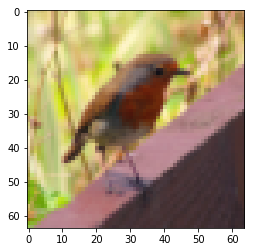

In [6]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


#### Exercise: Implement initialization for an L-layer Neural Network.

#### The model's structure is L-1 hidden layers with Relu activation and an output layer with sigmoid activation 


In [8]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):        
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
         
    return parameters

#### Forward propagation

In [9]:
def linear_forward(A, W, b):          
    
    Z = np.dot(W,A)+b 
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [10]:
def linear_activation_forward(A_prev, W, b, activation):
       
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)           
    elif activation == "relu":        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)    
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [11]:

def forward_propagation(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for l in range(1, L):
        A_prev = A                 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache) 
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache) 
    
    assert(AL.shape == (1, X.shape[1]))
            
    return AL, caches

#### Compute the cost

In [12]:
def compute_cost(AL, Y):        
    m = Y.shape[1]
    cost = (-1/m)*(np.sum(np.multiply(Y,np.log(AL))+np.multiply((1-Y),np.log(1-AL))))
    cost = np.squeeze(cost)      # To make sure  cost's shape is what we expect (e.g. this turns [[12]] into 12).
    assert(cost.shape == ())    
    return cost

#### Backward propagation

In [13]:
def linear_backward(dZ, cache):   
    A_prev, W, b = cache
    m = A_prev.shape[1]   
    dW = (1/m)*(np.dot(dZ,A_prev.T))
    db = (1/m)*(np.sum(dZ, axis=1, keepdims=True))
    dA_prev = np.dot(W.T,dZ)   
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [14]:
def linear_activation_backward(dA, cache, activation):
   
    linear_cache, activation_cache = cache    
    if activation == "relu":        
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)  
    elif activation == "sigmoid":       
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)     
    
    return dA_prev, dW, db

In [15]:
def backward_propagation(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation   
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))     
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
   
       
    for l in reversed(range(L-1)):        
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp 
        
    return grads


#### Update parameters

In [16]:
def update_parameters(parameters, grads, learning_rate):   
    
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate*grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate*grads["db" + str(l+1)])    
    return parameters

### L- Layer Model

In [17]:
### CONSTANTS ###
#layers_dims = [12288, 20, 7, 5, 1] #  4-layer model
layers_dims = [12288, 7,  1] #  2-layer model

In [18]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
   
    parameters = initialize_parameters(layers_dims)   
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.        
        AL, caches = forward_propagation(X, parameters)    
        
        # Compute cost.       
        cost = compute_cost(AL, Y)      
    
        # Backward propagation.       
        grads = backward_propagation(AL, Y, caches)       
 
        # Update parameters.       
        parameters = update_parameters(parameters, grads, learning_rate)        
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.figure(figsize=(10,10))
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.692380
Cost after iteration 100: 0.646159
Cost after iteration 200: 0.631775
Cost after iteration 300: 0.600091
Cost after iteration 400: 0.559427
Cost after iteration 500: 0.512988
Cost after iteration 600: 0.454815
Cost after iteration 700: 0.399388
Cost after iteration 800: 0.420515
Cost after iteration 900: 0.369184
Cost after iteration 1000: 0.362393
Cost after iteration 1100: 0.341366
Cost after iteration 1200: 0.333344
Cost after iteration 1300: 0.263797
Cost after iteration 1400: 0.164805
Cost after iteration 1500: 0.143608
Cost after iteration 1600: 0.124467
Cost after iteration 1700: 0.706752
Cost after iteration 1800: 0.092394
Cost after iteration 1900: 0.078572
Cost after iteration 2000: 0.068092
Cost after iteration 2100: 0.059649
Cost after iteration 2200: 0.052619
Cost after iteration 2300: 0.046817
Cost after iteration 2400: 0.041928


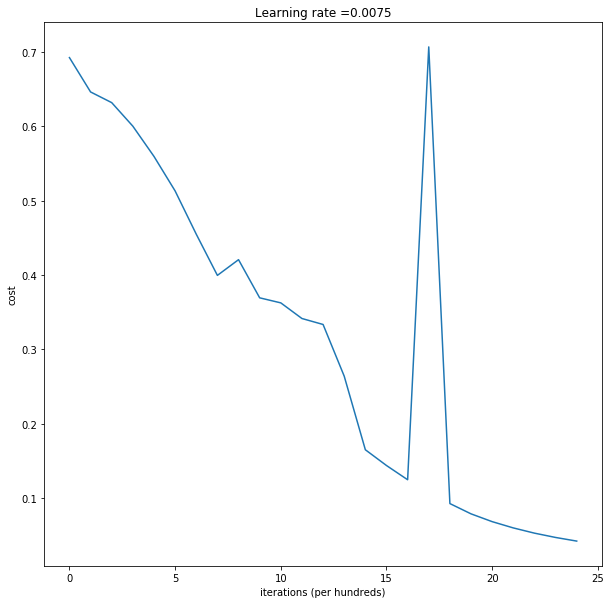

In [19]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [21]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = forward_propagation(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

In [22]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [23]:

predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


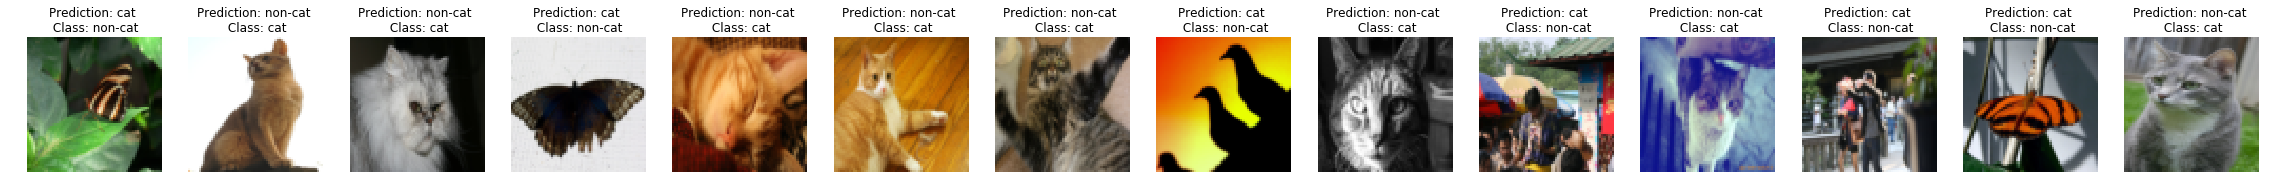

In [24]:
print_mislabeled_images(classes, test_x, test_y, predictions_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


Accuracy: 1.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


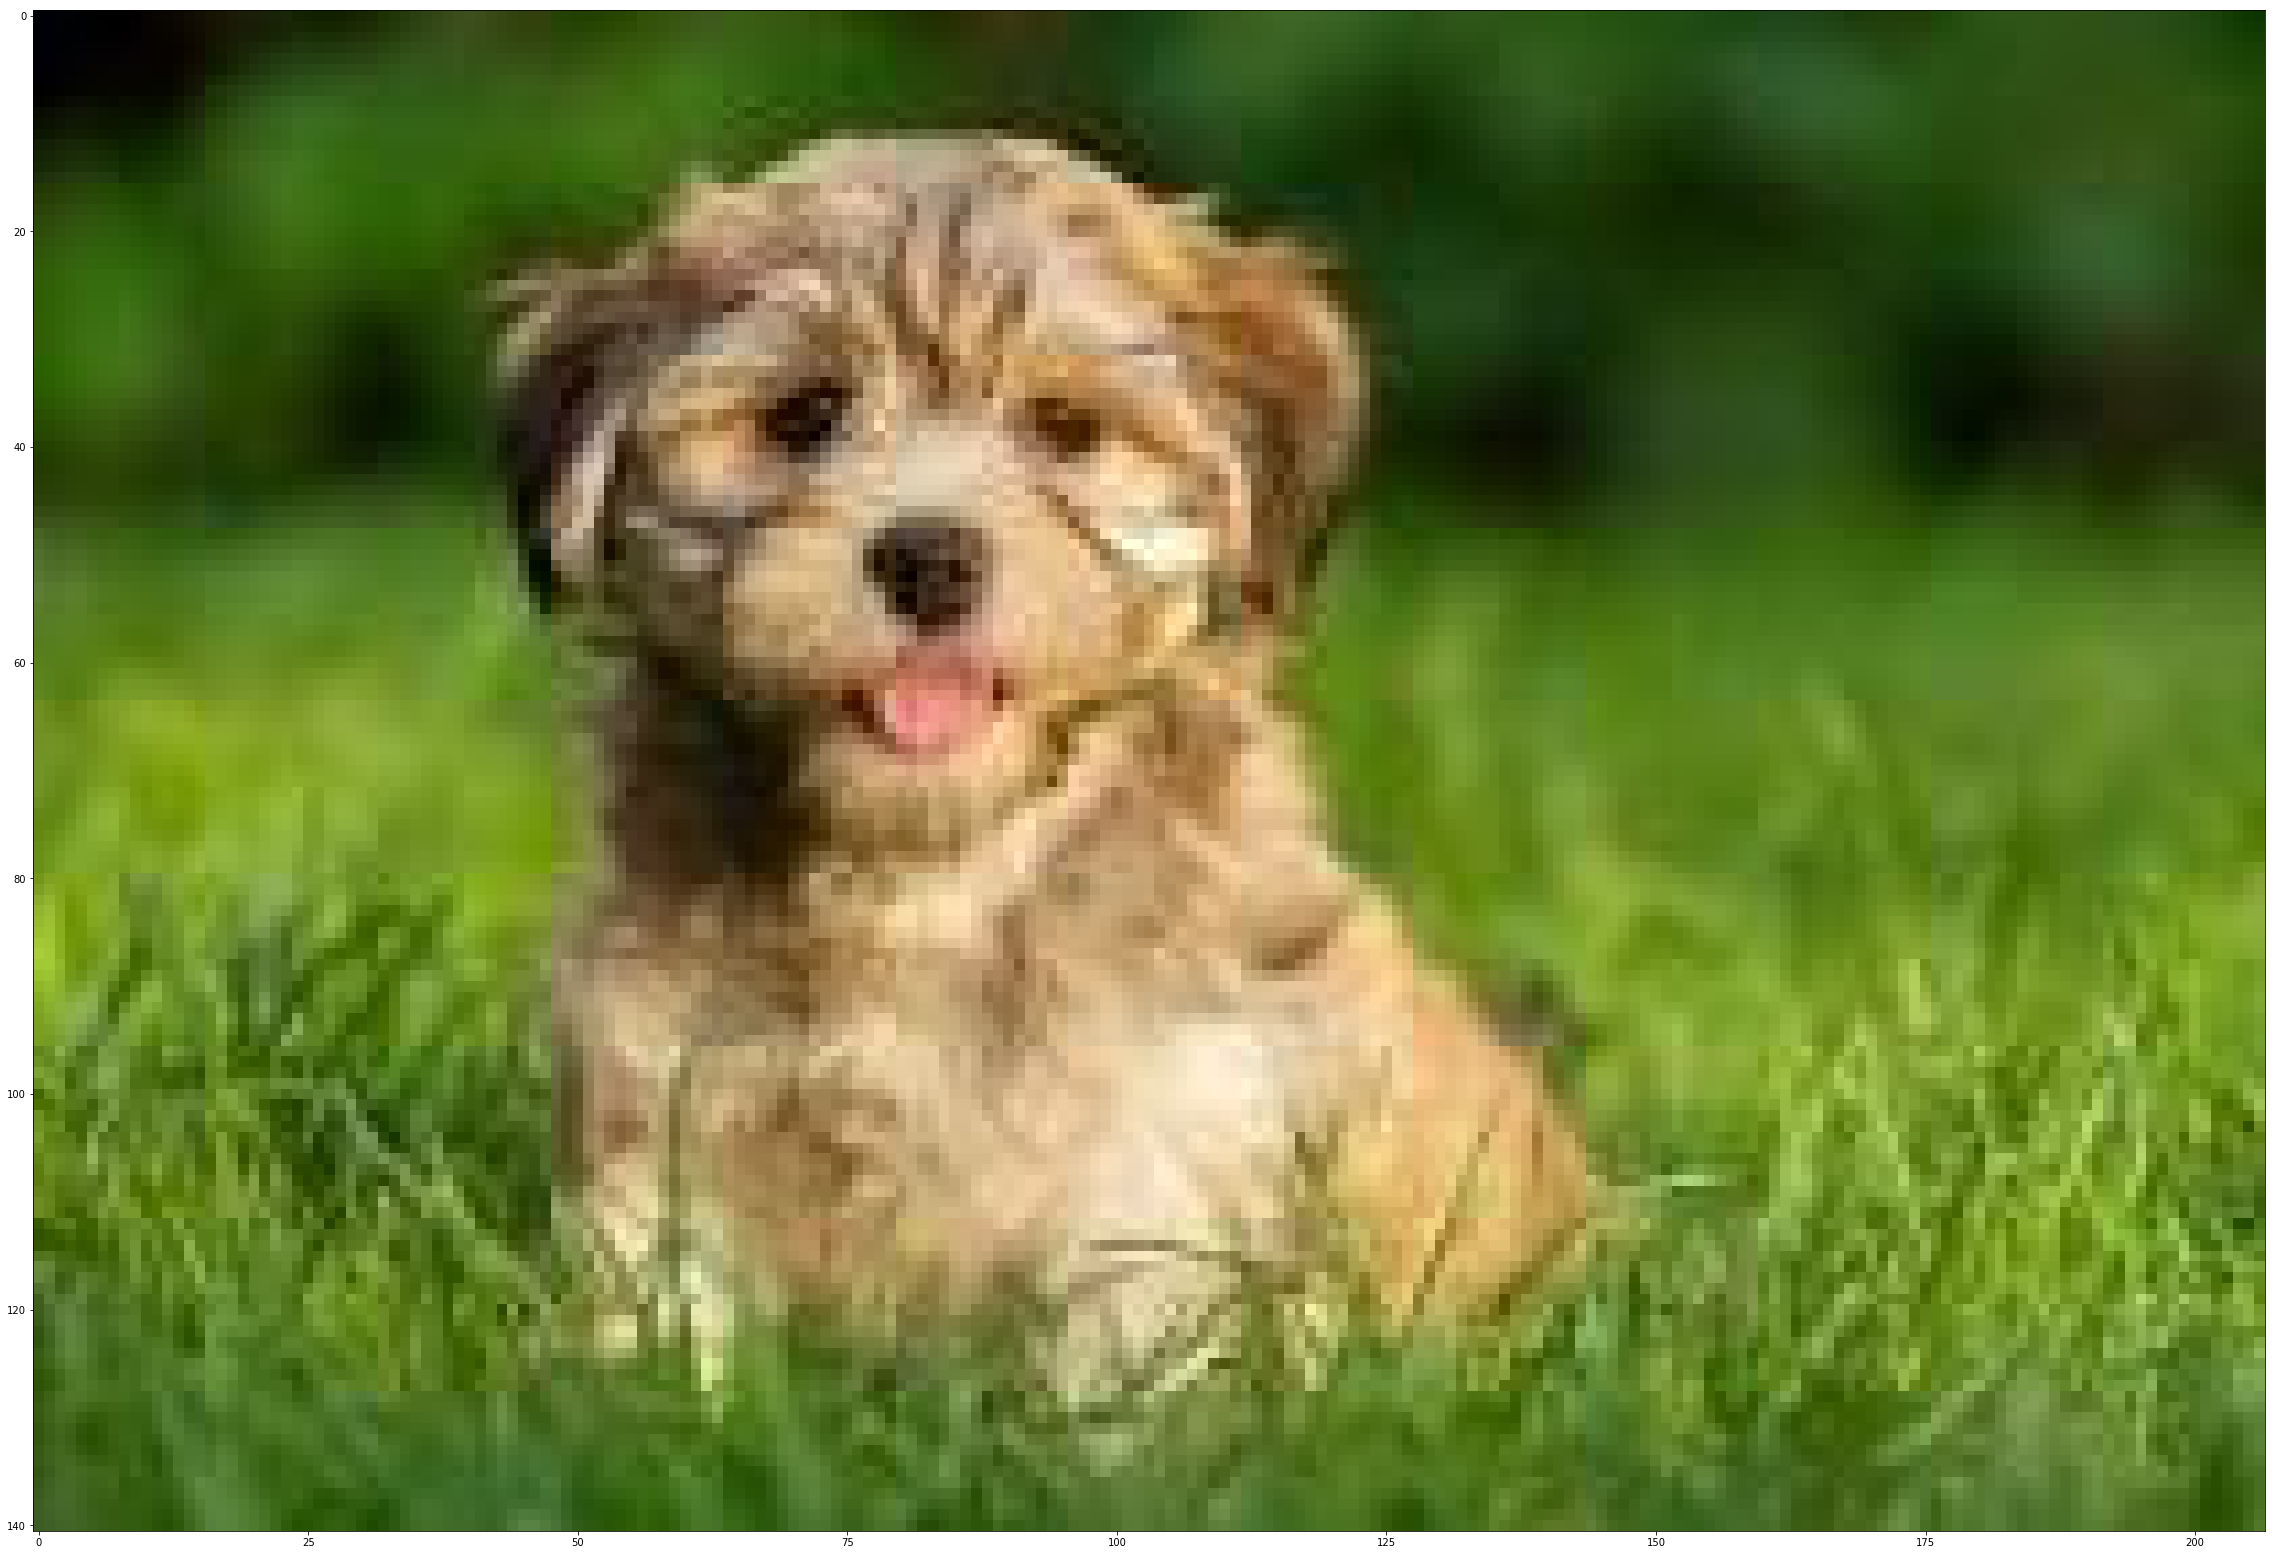

In [31]:
from scipy import misc
from PIL import Image

## Load an unseen image and predict it ##
my_image = "image_dog.jpg" # change this to the name of your image file 
my_label_y = [0] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "data/" + my_image
image = np.array(Image.open(fname))
my_image = misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")